**Sources**:
- [RFM and CLV: Using Iso-Value Curves for Customer Base Analysis](https://www.brucehardie.com/papers/rfm_clv_2005-02-16.pdf)
- [A Note on Implementing the Pareto/NBD Model in MATLAB](https://www.brucehardie.com/notes/008/)
- [Deriving an Expression for P(X(t)=x) Under the Pareto/NBD Model](http://www.brucehardie.com/notes/012/)
- [The Gamma-Gamma Model of Monetary Value](https://www.brucehardie.com/notes/025/)

In [81]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import beta, gamma, gammaln, factorial, hyp2f1, hyperu
from scipy.stats import pearsonr
from sklearn.neighbors import KernelDensity

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline
from IPython.display import display_markdown
from great_tables import GT

from utils import CDNOW, modified_silverman

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [82]:
rfm_summary_master = CDNOW(master=True, calib_p=273, remove_unauthorized=True).rfm_summary()
rfm_summary_sample = CDNOW(master=False, calib_p=273).rfm_summary()

repeat_trans_calib, repeat_trans_valid, last_purch, T = np.hsplit(rfm_summary_sample.collect().select('P1X', 'P2X', 't_x', 'T').to_numpy(), 4)
spend_calib, spend_valid = np.hsplit(rfm_summary_sample.collect().select('P1X Spend', 'P2X Spend').to_numpy(), 2)

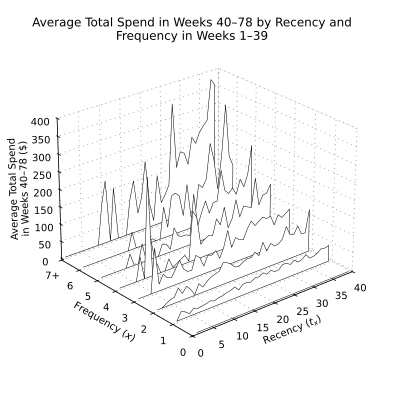

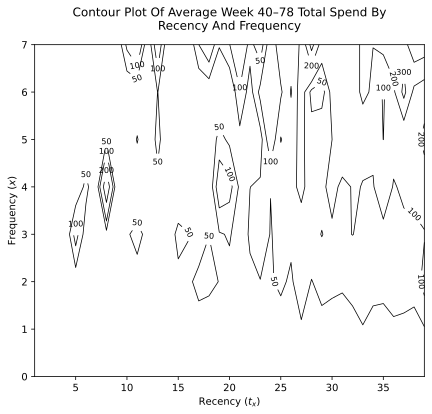

In [83]:
plot_data = (
    rfm_summary_master
    .with_columns((pl.col('p1rec') + 0.36).round(0).alias('rev_rec')) 
    .with_columns(pl.col('P1X').cut(np.arange(7)))
    .with_columns(pl.col('rev_rec').cut(np.arange(40)))
    .collect()
    .sort('rev_rec')
    .pivot(on='rev_rec', index='P1X', values='P2X Spend', aggregate_function='mean')
    .sort('P1X')
    .fill_null(0)
)

Y = np.arange(39) + 1
X = np.arange(8)
Z = plot_data[:,1:].to_numpy().T / 100
Z = np.where(X != 0, Z, 0)

# 3D Plot
fig, ax = plt.subplots(figsize=(10,7), dpi=100, subplot_kw={'projection': '3d'})

for i in range(8):
    ax.fill_between(i, Y, Z[:,i], i, Y, 0, facecolors='white', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Frequency ($x$)')
ax.set_ylabel('Recency ($t_{x}$)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Average Total Spend\nin Weeks 40–78 ($)', rotation=92)
ax.zaxis.labelpad = 7
ax.view_init(elev=25, azim=-40, roll=0) 

ax.set_xlim(7, 0)  
ax.set_ylim(0, 40) 
ax.set_zlim(-5, 400) 

ax.grid(True, linestyle=':', color='lightgray')

ax.xaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.yaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.zaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_box_aspect(None, zoom=0.84) 
ax.zaxis._axinfo['juggled'] = (1, 2, 0)
plt.xticks(X, labels=[str(i) if i < 7 else '7+' for i in range(8)])
plt.suptitle("Average Total Spend in Weeks 40–78 by Recency and\nFrequency in Weeks 1–39", y=0.86)
plt.show();

# Contour Plot
plt.figure(figsize=(7,6), dpi=100)
cs = plt.contour(Y, X, Z.T, levels=[50, 100, 200, 300], linewidths=0.75, colors='black')
plt.clabel(cs, fontsize=8)
plt.xlabel('Recency ($t_{x}$)')
plt.ylabel('Frequency ($x$)')
plt.title('Contour Plot Of Average Week 40–78 Total Spend By\nRecency And Frequency', pad=15);

Summary of Average Repeat Transaction Value per Customer (Weeks 1-39)

In [84]:
avg_spend_calib = (
    rfm_summary_sample
    .filter(pl.col('P1X') > 0)
    .with_columns(pl.col('zbar')/100)
    .rename({'zbar': 'Avg. Spend ($)'})
    .collect()
)

kurtosis = pl.DataFrame({'statistic': 'kurtosis',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').kurtosis())})
skew = pl.DataFrame({'statistic': 'skew',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').skew())})
mode = pl.DataFrame({'statistic': 'mode',
                     'Avg. Spend ($)': avg_spend_calib.select(pl.col('Avg. Spend ($)').mode())})

# SUMMARY OF AVERAGE REPEAT TRANSACTION VALUE PER CUSTOMER (WEEKS 1–39)
with pl.Config(tbl_rows=12):
    display(avg_spend_calib.select('Avg. Spend ($)').describe().vstack(mode).vstack(skew).vstack(kurtosis).with_columns(pl.col('Avg. Spend ($)').round(2)))

statistic,Avg. Spend ($)
str,f64
"""count""",946.0
"""null_count""",0.0
"""mean""",35.08
"""std""",30.28
"""min""",2.99
"""25%""",15.76
"""50%""",27.54
"""75%""",41.79
"""max""",299.63


The assumption that the distribution of average transaction values across customers is independent of the transaction process is central to the model of customer behavior we use to link RFM with CLV.

Using the transaction data for the 946 people who made at least one repeat purchase in Weeks 1–39 (of a sample of 2357 customers), we find that the simple correlation
between average transaction value and the number of transactions is 0.11.

In [86]:
corr_data = rfm_summary_sample.filter(pl.col('P1X') > 0).select('P1X', 'zbar').collect()
(
    corr_data.corr()
    .with_columns(pl.Series(corr_data.columns).alias("index"))
    .style.tab_header(title="Correlations Between Frequency & Monetary Value")
    .tab_stub(rowname_col="index")
    .fmt_number(decimals=3)
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (2, 3)
┌──────────┬──────────┬───────┐
│ P1X      ┆ zbar     ┆ index │
│ ---      ┆ ---      ┆ ---   │
│ f64      ┆ f64      ┆ str   │
╞══════════╪══════════╪═══════╡
│ 1.0      ┆ 0.113888 ┆ P1X   │
│ 0.113888 ┆ 1.0      ┆ zbar  │
└──────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x000002359557FC50>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.default: 1>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='zbar', type=<ColInfoTypeEnum.default: 1>, column_label='zbar', column_align='right', column_width=None), ColInfo(var='index', type=<ColInfoTypeEnum.stub: 2>, column_label='index', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000235954DC830>, _spanners=Spanners([]), _heading=Heading(title='Correlations Between Frequency & Monetary Value', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000023593AC6CF0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000002359551F140>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#000000'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#000000'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='he

The magnitude of the correlation is largely driven by one outlier: a customer who made 21 transactions in the 39-week period, with an average transaction value of
$300. If we remove this observation, the correlation between average transaction value and the number of transactions drops to .06 (p = .08).

In [98]:
corr_data = rfm_summary_sample.filter(pl.col('P1X') > 0).select('P1X', 'zbar').filter(pl.col('P1X') != 21).collect()

(
    corr_data.corr()
    .with_columns(pl.Series(corr_data.columns).alias("index"))
    .style.tab_header(title="Correlations Between Frequency & Monetary Value")
    .tab_stub(rowname_col="index")
    .fmt_number(decimals=3)
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (2, 3)
┌──────────┬──────────┬───────┐
│ P1X      ┆ zbar     ┆ index │
│ ---      ┆ ---      ┆ ---   │
│ f64      ┆ f64      ┆ str   │
╞══════════╪══════════╪═══════╡
│ 1.0      ┆ 0.056957 ┆ P1X   │
│ 0.056957 ┆ 1.0      ┆ zbar  │
└──────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x0000023593AC7F50>, _boxhead=Boxhead([ColInfo(var='P1X', type=<ColInfoTypeEnum.default: 1>, column_label='P1X', column_align='right', column_width=None), ColInfo(var='zbar', type=<ColInfoTypeEnum.default: 1>, column_label='zbar', column_align='right', column_width=None), ColInfo(var='index', type=<ColInfoTypeEnum.stub: 2>, column_label='index', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000235954DDE50>, _spanners=Spanners([]), _heading=Heading(title='Correlations Between Frequency & Monetary Value', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000023591E49580>, _formats=[<great_tables._gt_data.FormatInfo object at 0x0000023593AC7170>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#000000'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#000000'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='he

In [102]:
statistic, p_value = pearsonr(corr_data['P1X'].to_numpy(), corr_data['zbar'].to_numpy())
print(f'Statistic = {statistic:0.2f}, p-Value = {p_value:0.2f}')

Statistic = 0.06, p-Value = 0.08


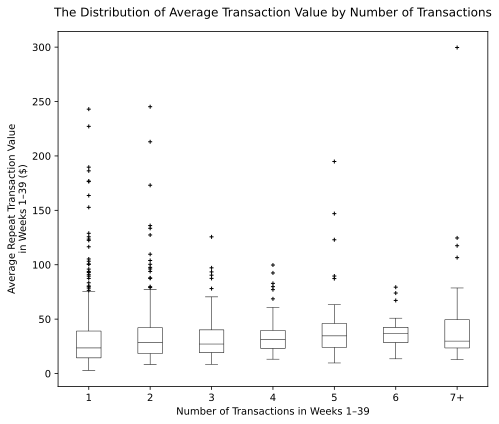

In [35]:
data = (
    avg_spend_calib
    .select('P1X', 'Avg. Spend ($)')
    .with_columns(pl.col('P1X').cut(np.arange(1,7), labels=[str(i) if i < 7 else '7+' for i in range(1,8)]))
)

plt.figure(figsize=(7,6), dpi=100)
sns.boxplot(x="P1X", y="Avg. Spend ($)", data=data, color='white', flierprops={"marker": "+", 'markersize': 4}, linecolor='black', linewidth=0.5, width=0.4)
plt.xlabel("Number of Transactions in Weeks 1–39")
plt.ylabel("Average Repeat Transaction Value\nin Weeks 1–39 ($)")
plt.title("The Distribution of Average Transaction Value by Number of Transactions", pad=15)
plt.tight_layout()
plt.show()

In [36]:
# Pareto/NBD Model
def paretonbd_likelihood(params, x, t_x, T):
    r, alpha, s, beta = params
    
    maxab = np.max((alpha, beta))
    absab = np.abs(alpha - beta)
    param2 = s + 1
    if alpha < beta:
        param2 = r + x
        
    part1 = (alpha**r * beta**s / gamma(r)) * gamma(r+x)
    part2 = 1/((alpha+T)**(r+x) * (beta+T)**s)

    if absab == 0:
        F1 = 1/((maxab+t_x)**(r+s+x))
        F2 = 1/((maxab+T)**(r+s+x))
    else:
        F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
        F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))        
    
    return part1*(part2+(s/(r+s+x))*(F1-F2))

def paretonbd_ll(params, x, t_x, T):
    return -np.sum(np.log(paretonbd_likelihood(params, x, t_x, T)))

def paretonbd_params(x, t_x, T):
    bnds = [(1e-6, 20) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(paretonbd_ll, x0=guess, bounds=bnds, args=(x, t_x, T))

def paretonbd_pmf(f_x, t, r, alpha, s, beta_param):
    '''
    P(X(t) = x | r, alpha, s, beta) where the random variable X(t) denotes the number of transactions in the 
    interval (0, t] for a randomly-chosen individual
    '''
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + f_x    
    B2i = np.cumsum(
        gamma(r+s+f_x)/gamma(r+s) * t**f_x / factorial(f_x) *
        hyp2f1(r+s+f_x, param2, r+s+f_x+1, absab/(maxab+t)) / 
        (maxab+t)**(r+s+f_x),
        axis=0
    )
    pmf = (
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) *
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x *
        (beta_param/(beta_param+t))**s +
        alpha**r * beta_param**s *
        beta(r+f_x,s+1)/beta(r,s) *
        (hyp2f1(r+s, param2, r+s+f_x+1, absab/maxab) / maxab**(r+s) - B2i)
    )
    return pmf

def paretonbd_E_X_t(t, r, alpha, s, beta_param):
    '''
    E[X(t) | r, alpha, s, beta], the expected number of transactions in a time period of length t
    central to computing the e thxpected transaction volume fore whole customer base over time
    '''
    return r*beta_param/(alpha*(s-1)) * (1 - (beta_param/(beta_param + t))**(s-1))

def paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param):
    '''
    P(“active”|r, alpha, s, beta, X = x, tx, T), the probability that a customer with observed 
    behavior (X = x, tx, T) is still active at time T
    '''
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + x

    F0 = (alpha + T)**(r + x) * (beta_param + T)**s

    if absab == 0:
        F1 = 1/((maxab+t_x)**(r+s+x))
        F2 = 1/((maxab+T)**(r+s+x))
    else:
        F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
        F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))       

    return (1 + (s / (r+s+x)) * F0 * (F1-F2))**(-1)

def paretonbd_E_Y_X(x, t_x, T, t, r, alpha, s, beta_param):
    '''
    E(Y(t)|X = x, tx, T, r, alpha, s, beta), the expected number of transactions in the future 
    period (T, T + t] for a customer with observed behavior (X = x, tx, T)
    '''
    return (
        (r + x) * (beta_param + T) / ((alpha + T) * (s - 1)) *
        (1 - ((beta_param + T) / (beta_param + T + t))**(s - 1)) *
        paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param)
    )
    
def paretonbd_cum_repeat_trans(n_s, s, t, r, alpha, s_param, beta_param, period=7):
    E_X_t = paretonbd_E_X_t(t, r, alpha, s_param, beta_param)
    s = np.arange(np.max(s)*period - 1, -1, -1, dtype=np.int32)
    t = np.arange(np.max(t)*period, dtype=np.int32).reshape(-1,1)
    index = np.clip(t - s, 0, len(E_X_t))
    E_X_t = np.where(t > s, E_X_t[index-1], 0)
    return np.dot(E_X_t, n_s)[6::7]

An annual discount rate of $(100 × d)$% is equivalent to a continuously compounded rate of $δ = ln(1 + d)$. If the data are recorded in time units such that there are $k$ periods per year ($k = 52$ if the data are recorded in weekly units of time), the relevant continuously compounded rate is $δ = ln(1 + d)/k$.

In [37]:
# Discounted Expected Transactions (DET)
def DET(x, t_x, T, delta, r, alpha, s, beta_param):
    '''
    `hyperu` - the confluent hypergeometric function of the second kind (also known as the Tricomi function).
    The confluent hypergeometric function of the second kind is expressed here in terms of the incomplete gamma function when a = c
    https://functions.wolfram.com/07.33.03.0003.01
    '''
    params = [r, alpha, s, beta_param]
    return (
        (alpha**r * beta_param**s * delta**(s-1) *
        gamma(r+x+1) * hyperu(s,s,delta*(beta_param+T))) / 
        (gamma(r) * (alpha+T)**(r+x+1) * paretonbd_likelihood(params, x, t_x, T))
    )

In [38]:
res = paretonbd_params(repeat_trans_calib, last_purch, T)
r_pareto, alpha_pareto, s, beta_param = res.x
ll = res.fun

display_markdown(f'''**Pareto/NBD:**

Parameter Estimates:
- $r$ = {r_pareto:0.4f}
- $\\alpha$ = {alpha_pareto:0.4f}
- $s$ = {s:0.4f}
- $\\beta$ = {beta_param:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

**Pareto/NBD:**

Parameter Estimates:
- $r$ = 0.5533
- $\alpha$ = 10.5785
- $s$ = 0.6064
- $\beta$ = 11.6741

Log-Likelihood = -9594.9762

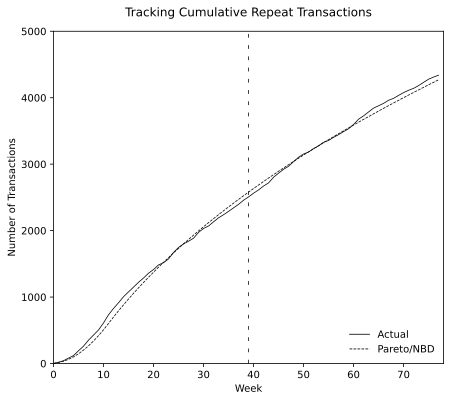

In [39]:
actual_cum_repeat, actual_wkly_sales, actual_cum_repeat = np.hsplit(CDNOW(master=False, calib_p=273).repeat_sales().to_numpy(), 3)

# n_s is the number of customers who made their first purchase on day s
# T_unique is the unique t - s/7 weeks within which to make repeat purchases
T_unique, n_s = np.unique(T, return_counts=True)

forecast_horizon = np.arange(1/7, 78, 1/7) # day-by-day in weeks
calib_p = 39 # in weeks

paretonbd_cum_repeat = paretonbd_cum_repeat_trans(n_s, calib_p-T_unique, forecast_horizon, r_pareto, alpha_pareto, s, beta_param)
paretonbd_wkly_repeat = np.diff(paretonbd_cum_repeat, prepend=0)

forecast_horizon = np.arange(78)
plt.figure(figsize=(7,6), dpi=100)
plt.plot(forecast_horizon, actual_cum_repeat, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(forecast_horizon, paretonbd_cum_repeat, color='black', linestyle='--', linewidth=0.75, label='Pareto/NBD')
plt.plot([calib_p for _ in range(5000)], [_ for _ in np.arange(5000)], color='black', linestyle=(0, (5, 10)), linewidth=0.75)
plt.xlabel("Week")
plt.ylabel("Number of Transactions")
plt.title('Tracking Cumulative Repeat Transactions', pad=15)
plt.ylim(0,5000)
plt.xlim(0, 78)
plt.legend(loc=4, frameon=False);

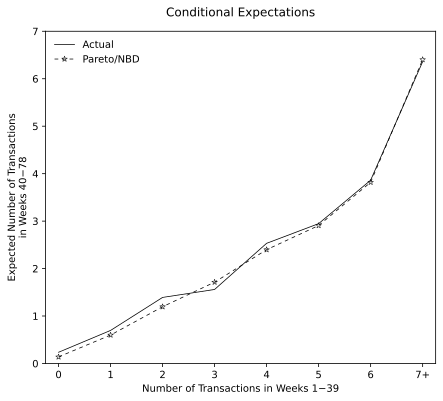

In [40]:
actual_ce = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary()
    .group_by('P1X').agg(pl.col('P2X').mean().alias('Actual CE'))
    .sort('P1X').select('Actual CE')
)

t = 39 # the length of the period over which we wish to make the conditional forecast
paretonbd_ce = paretonbd_E_Y_X(repeat_trans_calib, last_purch, T, t, r_pareto, alpha_pareto, s, beta_param)

paretonbd_ce, actual_ce  =  np.hsplit(
    pl.DataFrame({'x': repeat_trans_calib.astype(np.int32).flatten(), 
                  'Pareto/NBD -  E(Y|X)': paretonbd_ce.flatten()})
    .group_by('x')
    .agg(pl.col('Pareto/NBD -  E(Y|X)').mean())
    .sort('x').hstack(actual_ce.collect()).drop('x').to_numpy(), 2
)

censor = 7

num_repeats, repeat_freq = np.unique(repeat_trans_calib, return_counts=True)
num_repeats_censored = num_repeats[:censor+1].copy()

actual_ce_censored = actual_ce[:censor+1].copy()
actual_ce_censored[-1] = np.dot(repeat_freq[censor:], actual_ce[censor:]) / np.sum(repeat_freq[censor:])

paretonbd_ce_censored = paretonbd_ce[:censor+1].copy()
paretonbd_ce_censored[-1] = np.dot(repeat_freq[censor:], paretonbd_ce[censor:]) / np.sum(repeat_freq[censor:])

plt.figure(figsize=(7,6), dpi=100)
plt.plot(num_repeats_censored, actual_ce_censored, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(num_repeats_censored, paretonbd_ce_censored, color='black', linestyle=(0, (5, 5)), marker='*', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='Pareto/NBD')
plt.xlabel("Number of Transactions in Weeks 1−39")
plt.ylabel("Expected Number of Transactions\nin Weeks 40−78")
plt.title('Conditional Expectations', pad=15)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0,7)
plt.xlim(-0.25, 7.25)
plt.legend(loc=2, frameon=False); 

In [41]:
# Gamma-Gamma Model
def gammagamma_ll(params, x, zbar):
    p, q, gamma_param = params
    return -np.sum(
        gammaln(p*x+q)-gammaln(p*x)-gammaln(q) + 
        q*np.log(gamma_param)+(p*x-1)*np.log(zbar) + 
        (p*x)*np.log(x)-(p*x+q)*np.log(gamma_param+x*zbar)
    )

def gammagamma_params(x, zbar):

    guess=[0.01, 0.01, 0.01]
    bnds = [(1e-6, np.inf) for _ in range(3)]
    return minimize(gammagamma_ll, x0=guess, bounds=bnds, args=(x, zbar))

def f_zeta(zeta, p, q, gamma_param):
    '''
    f(ζ | p, q, gamma) 
    ζ = p/ν -> ν = p/ζ
    '''
    return (p * gamma_param)**q * zeta**(-q-1) * np.exp(-p*gamma_param/zeta) / gamma(q)

def gamma_posterior(nx, x, zbar, p, q, gamma_param):
    '''
    g(ν | p, q, γ; ¯z, x) posterior distribution of ν for a customer with an 
    average spend of zbar across x transactions
    ν = p/ζ
    nx:     count/number of total buyers with nx transactions
    x:      range of transactions
    zbar:   average repeat transaction value per customer
    '''
    # compute the density of zbar for each x
    a1 = gammaln(p*x+q)-gammaln(p*x)-gammaln(q)
    a2 = q*np.log(gamma_param)
    a3 = (p*x-1)*np.log(zbar)
    a4 = (p*x)*np.log(x)
    a5 = (p*x+q)*np.log(gamma_param+zbar*x)
    g1 = np.exp(a1+a2+a3+a4-a5)

    # compute the weighted average
    return np.dot(g1.T, nx) / np.sum(nx)

def gammagamma_ce(zbar, x, p, q, gamma_param):
    '''
    E(Z | p, q, γ; ¯z, x) conditional expectation of Z
    weighted average of the population mean, E(Z), and the observed average transaction value, ¯z. 
    zbar:   average repeat transaction value per customer
    x:      number of observations
    '''
    return (
        (q-1)/(p*x+q-1) * 
        (p*gamma_param)/(q-1) +
        (p*x / (p*x+q-1)) * zbar
    )

In [42]:
x, zbar = np.hsplit(avg_spend_calib.select('P1X','Avg. Spend ($)').to_numpy(), 2)
res = gammagamma_params(x=x, zbar=zbar)
p, q, gamma_param = res.x
ll = res.fun

display_markdown(f'''**Gamma-Gamma:**

$p$ = {p:0.4f}

$q$ = {q:0.4f}

$\\gamma$ = {gamma_param:0.4f}

Log-Likelihood = {-ll:0.4f}''', raw=True)

**Gamma-Gamma:**

$p$ = 6.2503

$q$ = 3.7441

$\gamma$ = 15.4413

Log-Likelihood = -4055.9177

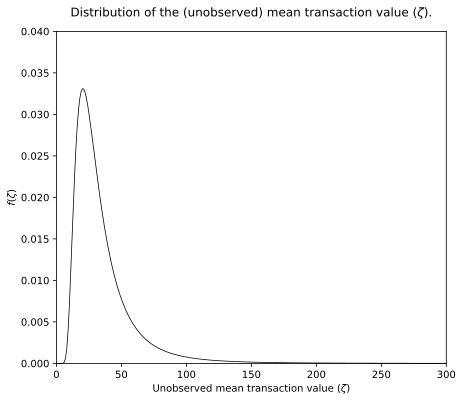

In [43]:
zeta = np.arange(300) + 1
inverse_gamma_dist = f_zeta(zeta, p, q, gamma_param)

plt.figure(figsize=(7,6), dpi=100)
plt.plot(zeta, inverse_gamma_dist, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.xlabel('Unobserved mean transaction value ($\\zeta$)')
plt.ylabel('$f(\\zeta)$')
plt.title('Distribution of the (unobserved) mean transaction value ($\\zeta$).', pad=15)
plt.ylim(0,0.04)
plt.xlim(0, 300);

Kernel Density Estimation (KDE) is a non-parametric technique used to estimate the probability density function (PDF) of a continuous random variable. It’s particularly useful when you want to visualize the underlying distribution of data without making any assumptions about its specific form (e.g., normal, exponential).

**How KDE Works**:
1. **Kernel Function**: A smooth, symmetric function (usually Gaussian, Epanechnikov, or uniform) that assigns weights to data points based on their distance from a given location.
2. **Bandwidth**: A parameter that determines the width of the kernel. It controls the degree of smoothing:
   - A smaller bandwidth results in a curve that closely follows the data but may be noisy (overfitting).
   - A larger bandwidth produces a smoother curve but may miss important details (underfitting).

The KDE is computed by centering the kernel function at each data point and summing their contributions across the domain.

**Why Do We Use KDE?**
1. **Visualizing Data Distribution**: KDE provides a smooth, continuous estimate of the distribution, making it easier to interpret than histograms, which can depend heavily on bin sizes.
2. **Handling Sparse Data**: KDE handles sparse or unevenly distributed data better than histograms, as it doesn't rely on bin edges.
3. **Unbiased Density Estimation**: KDE avoids the assumptions of specific parametric models, making it more flexible for exploring unknown distributions.
4. **Comparative Analysis**: It's useful for comparing multiple distributions visually by overlaying KDE plots.

In summary, KDE is a versatile tool for analyzing and visualizing the shape of a dataset’s distribution, especially when the underlying form is unknown or complex.

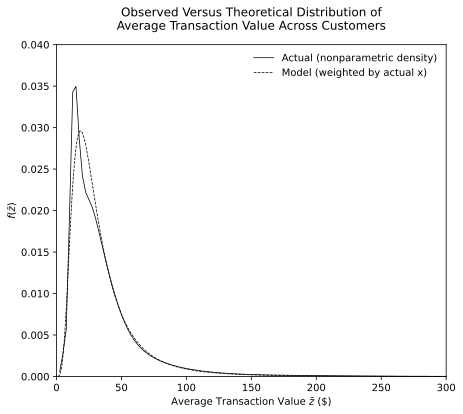

In [44]:
x_trans, nx = np.hsplit(
    rfm_summary_sample
    .filter(pl.col('P1X') > 0)
    .group_by('P1X')
    .agg(pl.len().alias('Count'))
    .sort('P1X').collect()
    .to_numpy(),
    2
)

zbar_range = np.arange(300) + 1
g = gamma_posterior(nx, x_trans, zbar_range, p, q, gamma_param)

# Kernel Density Estimation (Nonparametric)
m = np.arange(2.5, 301, 2.5) # Average transaction value range

# Apply log transformation for boundary correction
m_log = np.log(m)
zbar_log = np.log(zbar)

bw = modified_silverman(zbar_log)

# Estimate the probability density function
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(zbar_log.reshape(-1,1))
log_density = kde.score_samples(m_log.reshape(-1,1))
f = np.exp(log_density) / m # Transform the density back to the original scale

plt.figure(figsize=(7,6), dpi=100)
plt.plot(m, f, color='black', linestyle='solid', linewidth=0.75, label='Actual (nonparametric density)')
plt.plot(zbar_range, g, color='black', linestyle='dashed', linewidth=0.75, label='Model (weighted by actual x)')
plt.xlabel(r'Average Transaction Value $\bar{z}$ (\$)')
plt.ylabel(r'$f(\bar{z})$')
plt.title('Observed Versus Theoretical Distribution of\nAverage Transaction Value Across Customers', pad=15)
plt.ylim(0,0.04)
plt.xlim(0, 300)
plt.legend(frameon=False);

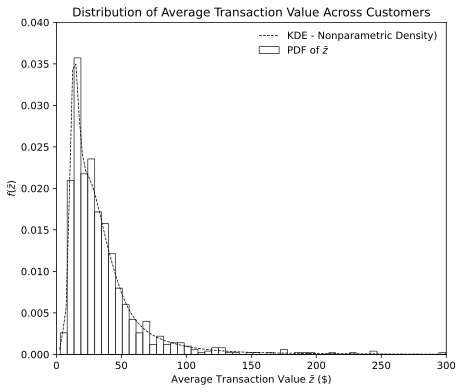

In [45]:
plt.figure(figsize=(7,6), dpi=100)
sns.histplot(zbar, stat='density', palette=['white'], label=r'PDF of $\bar{z}$')
sns.lineplot(x=m, y=f, linestyle='dashed', color='black', linewidth=0.75, label='KDE - Nonparametric Density)')
plt.title('Distribution of Average Transaction Value Across Customers')
plt.xlabel(r'Average Transaction Value $\bar{z}$ (\$)')
plt.ylabel(r'$f(\bar{z})$')
plt.legend(frameon=False)
plt.xlim(0, 300)
plt.ylim(0, 0.04)
plt.show()

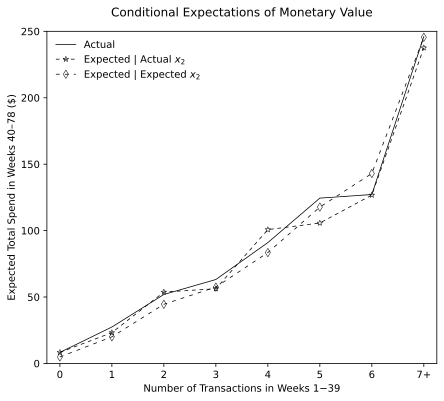

In [46]:
p1x, p2x, zbar = np.hsplit(rfm_summary_sample.collect().select('P1X', 'P2X','zbar').with_columns(pl.col('zbar')/100).to_numpy(), 3)
gamma_ce = gammagamma_ce(zbar, p1x, p, q, gamma_param)
exp_act_zbar = gamma_ce * p2x

paretonbd_ce = paretonbd_E_Y_X(repeat_trans_calib, last_purch, T, t, r_pareto, alpha_pareto, s, beta_param)
exp_exp_zbar = gamma_ce*paretonbd_ce

monetary_value = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary().collect()
    .hstack(
        pl.DataFrame({
            'exp_act_bar': exp_act_zbar.flatten(),
            'exp_exp_bar': exp_exp_zbar.flatten()
        })
    )
    .group_by('P1X')
    .agg(
        (pl.col('P2X Spend')/100).mean(),
        (pl.col('exp_act_bar')).mean(),
        (pl.col('exp_exp_bar')).mean()
    )
    .sort('P1X')
    .to_numpy()
)

censor = 7

actual_ce_censored = monetary_value[:,1][:censor+1].copy()
actual_ce_censored[-1] = np.dot(repeat_freq[censor:], monetary_value[:,1][censor:]) / np.sum(repeat_freq[censor:])

exp_act_zbar_cen = monetary_value[:,2][:censor+1].copy()
exp_act_zbar_cen[-1] = np.dot(repeat_freq[censor:], monetary_value[:,2][censor:]) / np.sum(repeat_freq[censor:])

exp_exp_zbar_cen = monetary_value[:,3][:censor+1].copy()
exp_exp_zbar_cen[-1] = np.dot(repeat_freq[censor:], monetary_value[:,3][censor:]) / np.sum(repeat_freq[censor:])

plt.figure(figsize=(7,6), dpi=100)
plt.plot(num_repeats_censored, actual_ce_censored, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(num_repeats_censored, exp_act_zbar_cen, color='black', linestyle=(0, (5, 5)), 
         marker='*', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='Expected | Actual $x_{2}$')
plt.plot(num_repeats_censored, exp_exp_zbar_cen, color='black', linestyle=(0, (5, 7)), 
         marker='d', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='Expected | Expected $x_{2}$')
plt.xlabel("Number of Transactions in Weeks 1−39")
plt.ylabel("Expected Total Spend in Weeks 40–78 ($)")
plt.title('Conditional Expectations of Monetary Value', pad=15)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0,250)
plt.xlim(-0.25, 7.25)
plt.legend(loc=2, frameon=False); 

Model Stability Overtime

In [54]:
full_data = CDNOW(master=False, calib_p=2*273).rfm_summary().select('P1X Spend', 'P1X', 't_x', 'T', 'zbar')

x_full, last_purch_full, T_full = np.hsplit(full_data.select('P1X', 't_x', 'T').collect().to_numpy(), 3)

res = paretonbd_params(x_full, last_purch_full, T_full)
r_pareto, alpha_pareto, s, beta_param = res.x
ll = res.fun

display_markdown(f'''**Pareto/NBD - Full Model:**

Parameter Estimates:
- $r$ = {r_pareto:0.4f}
- $\\alpha$ = {alpha_pareto:0.4f}
- $s$ = {s:0.4f}
- $\\beta$ = {beta_param:0.4f}

39-week loglikelihood (LL) function = {-paretonbd_ll([r_pareto, alpha_pareto, s, beta_param], repeat_trans_calib, last_purch, T):0.4f}''', raw=True)

**Pareto/NBD - Full Model:**

Parameter Estimates:
- $r$ = 0.5630
- $\alpha$ = 12.5581
- $s$ = 0.4078
- $\beta$ = 10.4929

39-week loglikelihood (LL) function = -9608.2366

In [55]:
x_full, zbar_full = np.hsplit(full_data.filter(pl.col('P1X') > 0).with_columns(pl.col('zbar')/100).select('P1X', 'zbar').collect().to_numpy(), 2)
x, zbar = np.hsplit(avg_spend_calib.select('P1X','Avg. Spend ($)').to_numpy(), 2)

res = gammagamma_params(x=x_full, zbar=zbar_full)
p, q, gamma_param = res.x
ll = res.fun

display_markdown(f'''**Gamma-Gamma - Full Model:**

$p$ = {p:0.4f}

$q$ = {q:0.4f}

$\\gamma$ = {gamma_param:0.4f}

39-week loglikelihood (LL) function = {-gammagamma_ll([p, q, gamma_param], x, zbar):0.4f}''', raw=True)

**Gamma-Gamma - Full Model:**

$p$ = 4.6845

$q$ = 4.1894

$\gamma$ = 24.3823

39-week loglikelihood (LL) function = -4058.0337

An annual discount rate of $(100 × d)$% is equivalent to a continuously compounded rate of $δ = ln(1 + d)$. If the data are recorded in time units such that there are $k$ periods per year ($k = 52$ if the data are recorded in weekly units of time), the relevant continuously compounded rate is $δ = ln(1 + d)/k$.

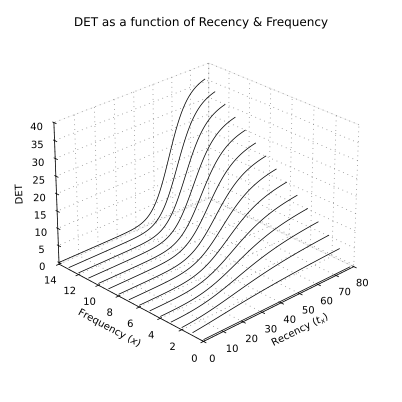

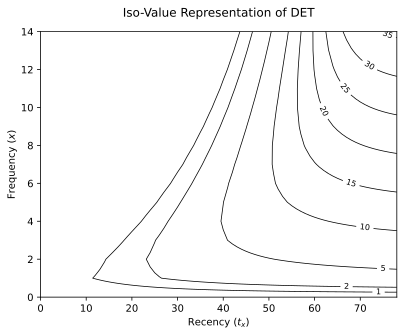

In [56]:
t_x_range = np.arange(79).reshape(-1,1)
x_range = np.arange(15)
T_constant = (2*273 - 1)/7
discount_rate = 0.15 # annual discount rate
delta = np.log(1 + discount_rate)/52 # continuously compounded rate

DET_Z = DET(x_range, t_x_range, T_constant, delta, r_pareto, alpha_pareto, s, beta_param)
DET_Z = np.where(x_range !=0, DET_Z, 0)

# 3D “waterfall” plot
fig, ax = plt.subplots(figsize=(6,6), dpi=200,subplot_kw={'projection': '3d'})

ax.plot_wireframe(x_range, t_x_range, DET_Z, rstride=0, cstride=1, color='black', linewidth=0.75)
ax.set_xlabel('Frequency ($x$)')
ax.set_ylabel('Recency ($t_{x}$)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('DET', rotation=92)
ax.set_xlim(14, 0)  
ax.set_ylim(0, 80) 
ax.set_zlim(-0.5, 40) 

ax.view_init(elev=27, azim=-44, roll=0) 

ax.grid(True, linestyle=':', color='lightgray')

ax.xaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.yaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.zaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_box_aspect(None, zoom=0.85) 
ax.zaxis._axinfo['juggled'] = (1, 2, 0)
plt.suptitle("DET as a function of Recency & Frequency", y=0.90)
plt.tight_layout()
plt.show();

# Iso-Value Representation of DET
contours = plt.contour(t_x_range.flatten(), x_range, DET_Z.T, levels=[1,2,5,10,15,20,25,30,35], linewidths=0.75, colors='black')
plt.clabel(contours, fontsize=8, inline=True)
plt.xlabel('Recency ($t_{x}$)')
plt.ylabel('Frequency ($x$)')
plt.title('Iso-Value Representation of DET', pad=15);

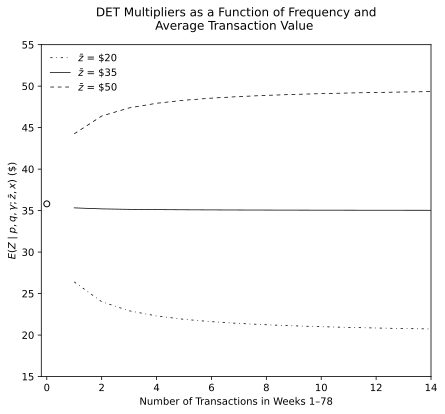

In [57]:
plt.figure(figsize=(7,6), dpi=100)
plt.plot(x_range[1:], gammagamma_ce(20, x_range[1:], p, q, gamma_param), color='black', linestyle=(0, (3, 5, 1, 5)), linewidth=0.75, label=r'$\bar{z}$ = \$20')
plt.plot(x_range[1:], gammagamma_ce(35, x_range[1:], p, q, gamma_param), color='black', linestyle='solid', linewidth=0.75, label=r'$\bar{z}$ = \$35')
plt.plot(x_range[1:], gammagamma_ce(50, x_range[1:], p, q, gamma_param), color='black', linestyle=(0, (5, 5)), linewidth=0.75, label=r'$\bar{z}$ = \$50')
plt.plot(0,gammagamma_ce(1, 0, p, q, gamma_param), 'ko', markerfacecolor="none") 
plt.xlabel("Number of Transactions in Weeks 1–78")
plt.ylabel(r'$E(Z \mid p,q,\gamma;\bar{z}, x)$ (\$)')
plt.title('DET Multipliers as a Function of Frequency and\nAverage Transaction Value ', pad=15)
plt.ylim(15,55)
plt.xlim(-0.2, 14)
plt.legend(loc=0, frameon=False);

$$CLV = \text{Margin} \times \text{Revenue/Transaction} \times DET$$

In [49]:
def CLV(margin, delta, x, t_x, zbar, T, r, alpha, s, beta_param, p, q, gamma_param):
    '''
    margin: Gross Contribution Margin
    delta:  Discount Rate (continuously compounded rate adjusted 
            for unit of time)
    x:      Frequency
    t_x:    Recency
    zbar:   Average Transaction Value
    T:      Effective Calibration Period
    
    Pareto/NBD Parameters: r, alpha, s, beta
    Gamma-Gamma Parameters: p, q, gamma
    '''
    det = DET(x, t_x, T, delta, r, alpha, s, beta_param)
    rev_per_trans = gammagamma_ce(zbar, x, p, q, gamma_param)
    return margin * rev_per_trans * det

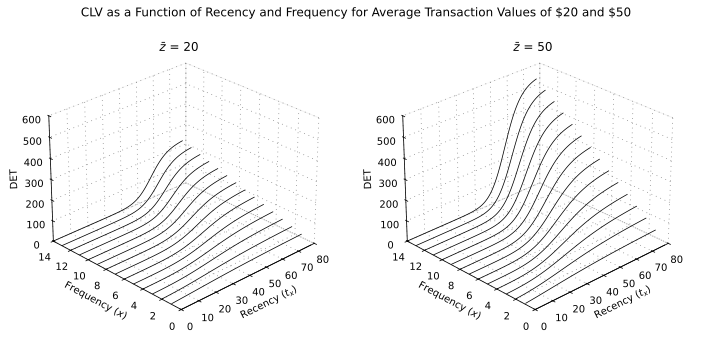

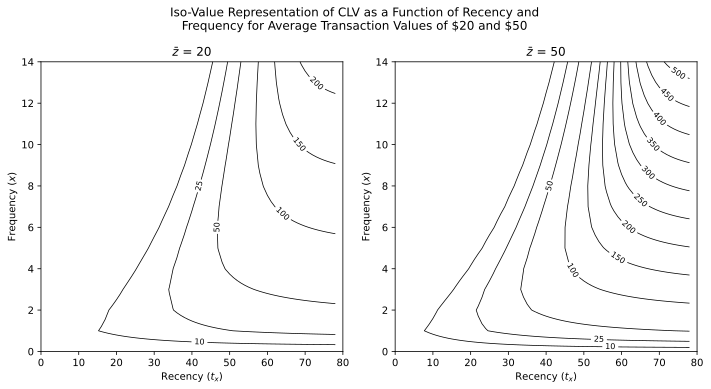

In [58]:
cm = 0.3 # gross contribution margin
zbar_list = [20, 50]

# 3D “waterfall” plot
fig, ax = plt.subplots(1, 2, figsize=(10,8), dpi=200, subplot_kw={'projection': '3d'})
for i, sub in enumerate(ax):
    CLV_Z = CLV(cm, delta, x_range, t_x_range, zbar_list[i], T_constant, r_pareto, alpha_pareto, s, beta_param, p, q, gamma_param)
    CLV_Z = np.where(x_range != 0, CLV_Z, 0)
    sub.plot_wireframe(x_range, t_x_range, CLV_Z, rstride=0, cstride=1, color='black', linewidth=0.75)
    sub.set_xlabel('Frequency ($x$)')
    sub.set_ylabel('Recency ($t_{x}$)')
    sub.zaxis.set_rotate_label(False)
    sub.set_zlabel('DET', rotation=92)
    sub.set_title(r"$\bar{{z}}$ = " + f"{zbar_list[i]}", y=0.95)
    sub.set_xlim(14, 0)  
    sub.set_ylim(0, 80) 
    sub.set_zlim(-0.5, 600) 

    sub.view_init(elev=27, azim=-44, roll=0) 
    sub.grid(True, linestyle=':', color='lightgray')
    sub.xaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
    sub.yaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
    sub.zaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})

    sub.xaxis.pane.fill = False
    sub.yaxis.pane.fill = False
    sub.zaxis.pane.fill = False

    sub.set_box_aspect(None, zoom=0.85) 
    sub.zaxis._axinfo['juggled'] = (1, 2, 0)

plt.suptitle('CLV as a Function of Recency and Frequency for Average Transaction Values of \\$20 and \\$50', y=0.79)
plt.tight_layout()
plt.show();

# Iso-Value Representation of DET
fig, ax = plt.subplots(1, 2, figsize=(10,5.5), dpi=200)
for i, sub in enumerate(ax):
    CLV_Z = CLV(cm, delta, x_range, t_x_range, zbar_list[i], T_constant, r_pareto, alpha_pareto, s, beta_param, p, q, gamma_param)
    CLV_Z = np.where(x_range != 0, CLV_Z, 0)
    contours = sub.contour(t_x_range.flatten(), x_range, CLV_Z.T, levels=[10,25,50,100,150,200,250,300,350,400,450,500], linewidths=0.75, colors='black')
    sub.clabel(contours, fontsize=8, inline=True)
    sub.set_xlabel('Recency ($t_{x}$)')
    sub.set_ylabel('Frequency ($x$)')
    sub.set_xlim(0,80)
    sub.set_ylim(0,14)
    sub.set_title(r"$\bar{{z}}$ = " + f"{zbar_list[i]}")
    
plt.suptitle('Iso-Value Representation of CLV as a Function of Recency and\nFrequency for Average Transaction Values of \\$20 and \\$50')
plt.tight_layout()
plt.show();

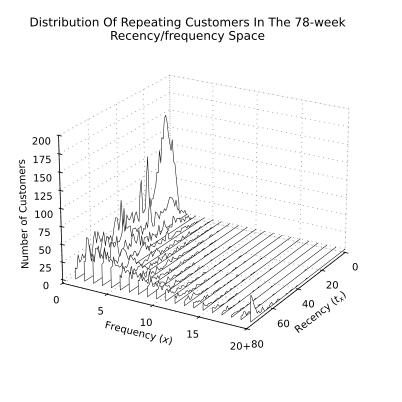

In [59]:
plot_data = (
    CDNOW(master=True, calib_p=2*273, remove_unauthorized=True)
    .rfm_summary()
    .filter(pl.col('P1X') > 0)
    .with_columns((pl.col('p1rec') + 0.36).round(0)) 
    .with_columns(
        pl.col('P1X').cut(np.arange(20)),
        pl.col('p1rec').cut(np.arange(80))    
    ).collect()
    .sort('p1rec')
    .pivot(on='p1rec', index='P1X', values='ID', aggregate_function='len')
    .sort('P1X')
    .fill_null(0)
)

Y = np.arange(78) 
X = np.arange(20)
Z = plot_data[:,1:].to_numpy().T

# 3D Plot
fig, ax = plt.subplots(figsize=(15,7), dpi=100, subplot_kw={'projection': '3d'})
for i in range(1, 21):
    ax.fill_between(i, Y, Z[:,i-1], i, Y, 0, facecolors='white', edgecolor='black', linewidth=0.5)

ax.set_xlabel('Frequency ($x$)')
ax.set_ylabel('Recency ($t_{x}$)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Number of Customers', rotation=92)
ax.view_init(elev=22, azim=120, roll=0) 

ax.set_xlim(19, 0)  
ax.set_ylim(0, 80) 
ax.set_zlim(-5, 200) 

ax.grid(True, linestyle=':', color='lightgray')

ax.xaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.yaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})
ax.zaxis._axinfo['grid'].update({'linestyle': (0, (1, 5)), 'color': 'gray'})

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False 

custom_ticks = np.arange(0, 21, 5)
custom_labels = [str(i) if i < 20 else '20+' for i in custom_ticks]

ax.set_box_aspect(None, zoom=0.84) 
ax.zaxis._axinfo['juggled'] = (1, 2, 0)
ax.set_xticks(custom_ticks)          
ax.set_xticklabels(custom_labels) 
ax.set_yticks(np.arange(0, 81, 20))
plt.suptitle("Distribution Of Repeating Customers In The 78-week\nRecency/frequency Space", y=0.86)
plt.show();

In [88]:
def CLV_df(x, t_x, zbar, T):
    return CLV(margin=cm, delta=delta, 
               x=x, t_x=t_x, zbar=zbar, 
               T=T, r=r_pareto, alpha=alpha_pareto, 
               s=s, beta_param=beta_param,
               p=p, q=q, gamma_param=gamma_param)

rfm_group = (
    CDNOW(master=True, calib_p=2*273, remove_unauthorized=True)
    .rfm_summary()
    .filter(pl.col('P1X') > 0)
    .with_columns((pl.col('p1rec') + 0.36).round(0)) 
    .sort('ID')
    .with_columns(
        pl.col('p1rec').rank(method='ordinal', descending=False).alias('Recency Rank'),
        pl.col('P1X').rank(method='ordinal', descending=False).alias('Frequency Rank'),
        pl.col('zbar').rank(method='ordinal', descending=False).alias('Monetary Rank')
    ).with_columns(
        (np.floor(3 * (pl.col('Recency Rank') - 1) / pl.col('Recency Rank').max()) + 1).cast(pl.UInt16).alias('Recency Tercile'),
        (np.floor(3 * (pl.col('Frequency Rank') - 1) / pl.col('Frequency Rank').max()) + 1).cast(pl.UInt16).alias('Frequency Tercile'),
        (np.floor(3 * (pl.col('Monetary Rank') - 1) / pl.col('Monetary Rank').max()) + 1).cast(pl.UInt16).alias('Monetary Tercile')
    ).select('ID', 'Recency Tercile', 'Frequency Tercile', 'Monetary Tercile')
    .join(
        other=CDNOW(master=True, calib_p=2*273, remove_unauthorized=True).rfm_summary(),
        on='ID', how='right'
    ).fill_null(0)
    .with_columns(
        pl.struct(['P1X', 't_x', 'zbar', 'T'])
        .map_batches(
            lambda cols: CLV_df(
                cols.struct.field('P1X'), 
                cols.struct.field('t_x'), 
                cols.struct.field('zbar')/100, 
                cols.struct.field('T')
            )
        )
        .alias("CLV")
    )    
)

rfm_count_crosstab = (
    rfm_group
    .group_by('Recency Tercile', 'Frequency Tercile', 'Monetary Tercile').agg(pl.len().alias('Count'))
    .sort('Recency Tercile', 'Frequency Tercile', 'Monetary Tercile')
    .collect()
    .pivot(on='Recency Tercile', index=['Monetary Tercile', 'Frequency Tercile'], values='Count')   
    .sort('Monetary Tercile')
    .select('Monetary Tercile', 'Frequency Tercile', '0', '1', '2', '3')
)

(
    GT(rfm_count_crosstab, rowname_col='Frequency Tercile', groupname_col='Monetary Tercile')
    .tab_spanner(label='Recency', columns=['0', '1', '2', '3'])
    .tab_stubhead('Frequency')
    .fmt_number(use_seps=True, decimals=0)
    .sub_missing(
        columns=['0','1','2','3'],
        missing_text=""
    )    
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (10, 6)
┌──────────────────┬───────────────────┬───────┬──────┬──────┬──────┐
│ Monetary Tercile ┆ Frequency Tercile ┆ 0     ┆ 1    ┆ 2    ┆ 3    │
│ ---              ┆ ---               ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u16              ┆ u16               ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞══════════════════╪═══════════════════╪═══════╪══════╪══════╪══════╡
│ 0                ┆ 0                 ┆ 12054 ┆ null ┆ null ┆ null │
│ 1                ┆ 1                 ┆ null  ┆ 1129 ┆ 476  ┆ 147  │
│ 1                ┆ 2                 ┆ null  ┆ 438  ┆ 497  ┆ 348  │
│ 1                ┆ 3                 ┆ null  ┆ 61   ┆ 252  ┆ 488  │
│ 2                ┆ 1                 ┆ null  ┆ 616  ┆ 245  ┆ 131  │
│ 2                ┆ 2                 ┆ null  ┆ 394  ┆ 555  ┆ 356  │
│ 2                ┆ 3                 ┆ null  ┆ 87   ┆ 476  ┆ 975  │
│ 3                ┆ 1                 ┆ null  ┆ 641  ┆ 342  ┆ 109  │
│ 3                ┆ 2                 ┆ null  ┆ 367  ┆ 527  ┆ 353  │
│ 3                ┆ 3                 ┆ null  ┆ 103  ┆ 465  ┆ 928  │
└──────────────────┴───────────────────┴───────┴──────┴──────┴──────┘, _body=<great_tables._gt_data.Body object at 0x00000235954DF560>, _boxhead=Boxhead([ColInfo(var='Monetary Tercile', type=<ColInfoTypeEnum.row_group: 3>, column_label='Monetary Tercile', column_align='center', column_width=None), ColInfo(var='Frequency Tercile', type=<ColInfoTypeEnum.stub: 2>, column_label='Frequency Tercile', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='0', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='1', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='2', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='3', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000235954DC770>, _spanners=Spanners([SpannerInfo(spanner_id='Recency', spanner_level=0, spanner_label='Recency', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead='Frequency', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x00000235954DC320>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000235954DE6C0>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x00000235954DDFA0>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo

In [87]:
rfm_clv_crosstab = (
    rfm_group
    .group_by('Recency Tercile', 'Frequency Tercile', 'Monetary Tercile').agg(pl.col('CLV').sum())
    .sort('Recency Tercile', 'Frequency Tercile', 'Monetary Tercile')
    .collect()
    .pivot(on='Recency Tercile', index=['Monetary Tercile', 'Frequency Tercile'], values='CLV')   
    .sort('Monetary Tercile')
    .select('Monetary Tercile', 'Frequency Tercile', '0', '1', '2', '3')
)

(
    GT(rfm_clv_crosstab, rowname_col='Frequency Tercile', groupname_col='Monetary Tercile')
    .tab_spanner(label='Recency', columns=['0', '1', '2', '3'])
    .tab_stubhead('Frequency')
    .fmt_number(use_seps=True, decimals=0)
    .sub_missing(
        columns=['0','1','2','3'],
        missing_text=""
    )    
    .opt_stylize(style=1, color='gray')
)

GT(_tbl_data=shape: (10, 6)
┌──────────────────┬───────────────────┬─────────────┬──────────────┬──────────────┬───────────────┐
│ Monetary Tercile ┆ Frequency Tercile ┆ 0           ┆ 1            ┆ 2            ┆ 3             │
│ ---              ┆ ---               ┆ ---         ┆ ---          ┆ ---          ┆ ---           │
│ u16              ┆ u16               ┆ f64         ┆ f64          ┆ f64          ┆ f64           │
╞══════════════════╪═══════════════════╪═════════════╪══════════════╪══════════════╪═══════════════╡
│ 0                ┆ 0                 ┆ 53099.18423 ┆ null         ┆ null         ┆ null          │
│ 1                ┆ 1                 ┆ null        ┆ 7151.753066  ┆ 9705.052233  ┆ 3789.941321   │
│ 1                ┆ 2                 ┆ null        ┆ 3127.286582  ┆ 15318.807584 ┆ 15557.313065  │
│ 1                ┆ 3                 ┆ null        ┆ 303.376924   ┆ 12381.039173 ┆ 53197.719998  │
│ 2                ┆ 1                 ┆ null        ┆ 5573.665486  ┆ 7046.015917  ┆ 4638.284843   │
│ 2                ┆ 2                 ┆ null        ┆ 3913.413795  ┆ 26734.583545 ┆ 23660.764978  │
│ 2                ┆ 3                 ┆ null        ┆ 479.843953   ┆ 37437.745113 ┆ 203048.831136 │
│ 3                ┆ 1                 ┆ null        ┆ 10797.785999 ┆ 18381.878459 ┆ 7187.636698   │
│ 3                ┆ 2                 ┆ null        ┆ 7729.419799  ┆ 47295.787457 ┆ 45623.915989  │
│ 3                ┆ 3                 ┆ null        ┆ 1286.618537  ┆ 68240.267956 ┆ 408381.783792 │
└──────────────────┴───────────────────┴─────────────┴──────────────┴──────────────┴───────────────┘, _body=<great_tables._gt_data.Body object at 0x0000023592F45A30>, _boxhead=Boxhead([ColInfo(var='Monetary Tercile', type=<ColInfoTypeEnum.row_group: 3>, column_label='Monetary Tercile', column_align='center', column_width=None), ColInfo(var='Frequency Tercile', type=<ColInfoTypeEnum.stub: 2>, column_label='Frequency Tercile', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='0', column_align='right', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='1', column_align='right', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='2', column_align='right', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='3', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000023592ED60C0>, _spanners=Spanners([SpannerInfo(spanner_id='Recency', spanner_level=0, spanner_label='Recency', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead='Frequency', _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000023592F445C0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x00000235954FC620>], _substitutions=[<great_tables._gt_data.FormatInfo object at 0x0000023592F45E50>], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-se